In [610]:
import torch

### Automatic Differentiation

Calculating derivatives is the crucial step in all the optimization algorithms that we will use to train deep networks. Modern deep learning frameworks take this work off our plates by offering automatic differentiation (often shortened to autograd).

### Exmplanation based on a simple function

**y = 2x<sup>T</sup>x**, where **x** is an vector

In [611]:
x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

Before gradien calculation, we need a place to store it. Because of the calculation complexity in real-life scenarios and how much data needs to be processed and stored - memory management is crucial to not run out of it.
For this, gradiend with the respect to vector **x**  we can store **in that vector**. 

In [612]:
x.requires_grad_(True)
# We can also define this when creating a tensor by x = torch.arange(4.0, requires_grad=True)

# Gradient for now is None by default
print(x.grad)

None


In [613]:
# You can also use "matmul" but the executed algoright vary on the input, while using "dot" you specify wich exactly algorimth you want to use
# dot product = scalar product (pl. iloczyn skalarny)
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

In [614]:
x.grad # Still None
y.backward() # Take the gradient of y with respect to x by calling its backward method - "x" gradient will be now filled
x.grad

tensor([ 0.,  4.,  8., 12.])

In [615]:
# Gradient function with respect to the **x** should be:

# y' = 2 * (x * x)
# (x * x) is essentially (x ** 2)
# y' = 2 * (x ** 2)
# y' = 4 * x

x.grad == 4 * x

tensor([True, True, True, True])

In [616]:
y = x.sum()
y.backward()
y

tensor(6., grad_fn=<SumBackward0>)

In [617]:
x.grad 
# Result - tensor([ 1.,  5.,  9., 13.])
# Because PyTorch does NOT automatically resey the gradient buffer.
# Instead, the new gradient is added to the already-stored gradient. 
# This behavior comes in handy when we want to optimize the sum of multiple objective functions.

tensor([ 1.,  5.,  9., 13.])

In [618]:
# In order to reset the gradient use "grad.zero_()"
x.grad.zero_()
y = x.sum()
y.backward()

print(f"x: {x}")
print(f"y: {y}")
print(f"x.grad: {x.grad}")

x: tensor([0., 1., 2., 3.], requires_grad=True)
y: 6.0
x.grad: tensor([1., 1., 1., 1.])


### Backward for Non-Scalar Variables

In [619]:
x.grad.zero_()
y = x * x
# Just running "y.backward()" will result in Error - RuntimeError: grad can be implicitly created only for scalar outputs (for operations that result is a scalar)
# By providing gradient you are providing what backward() should compute agains and how gradient resoult should be presented, so "v * dx * y", instead of "dx * y" by default

y.backward(gradient=torch.ones(len(y))) # Faster: y.sum().backward()

print(f"x: {x}")
print(f"y: {y}")
print(f"x.grad: {x.grad}")

x: tensor([0., 1., 2., 3.], requires_grad=True)
y: tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
x.grad: tensor([0., 2., 4., 6.])


### Detaching Computation

In order to move some calculations outside of the recorded computational graph - so the calculation will not be included in the grandient, we need to detach the respective computational graph from the final result.

Suppose we have **z = x * y** and **y = x * x** but we want to focus on the direct influence of **x** on **z** rather than the influence conveyed via **y**.

So we want **x affects z**, NOT **x affects y affects z**.

In [620]:
x.grad.zero_()

y = x * x
u = y.detach()
# Create a new variable u that takes the same value as y but whose provenance (how it was created) has been wiped out. 
# Thus u has no ancestors in the graph and gradients do not flow through u to x

z = u * x
z.sum().backward()

print(f"x: {x}")
print(f"y: {y}")
print(f"z: {z}")
print(f"x.grad: {x.grad}")
x.grad == u

x: tensor([0., 1., 2., 3.], requires_grad=True)
y: tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)
z: tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>)
x.grad: tensor([0., 1., 4., 9.])


tensor([True, True, True, True])

In [621]:
# Procedure above detaches y’s ancestors from the graph leading to z,
# the computational graph leading to y persists and thus we can calculate the gradient of y with respect to x.
x.grad.zero_()
y.sum().backward()

print(f"x: {x}")
print(f"y: {y}")
x.grad, x.grad == 2 * x

x: tensor([0., 1., 2., 3.], requires_grad=True)
y: tensor([0., 1., 4., 9.], grad_fn=<MulBackward0>)


(tensor([0., 2., 4., 6.]), tensor([True, True, True, True]))

In [622]:
x.grad.zero_()
o = x * x * x
o.sum().backward()

x, o, x.grad

(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor([ 0.,  1.,  8., 27.], grad_fn=<MulBackward0>),
 tensor([ 0.,  3., 12., 27.]))

### Gradients and Python Control Flow

In [623]:
def f(a: torch.Tensor):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

a, d, a.grad, a.grad == d / a

(tensor(-0.5568, requires_grad=True),
 tensor(-114028.8125, grad_fn=<MulBackward0>),
 tensor(204800.),
 tensor(True))

### Conclusion and exercises

For now, try to remember these basics:
1. attach gradients to those variables with respect to which we desire derivatives;
2. record the computation of the target value;
3. execute the backpropagation function;
4. and access the resulting gradient.

In [624]:
# 2 - running backward() twice result in an error, BUT according to the error message,
# you can use retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward
x = torch.arange(4.0, requires_grad=True)
y = 2 * torch.dot(x, x)
y.backward(retain_graph=True)
y.backward()
x, y, x.grad

# Next backpropagation will be calculaten on top of the first result
# First calculated grad is - tensor([ 0.,  4.,  8., 12.])
# So the second will be calculatedo ntop of that, and result is - tensor([ 0.,  8., 16., 24.])


(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor(28., grad_fn=<MulBackward0>),
 tensor([ 0.,  8., 16., 24.]))

In [625]:
# 3
def u(a: torch.Tensor):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.arange(4.0, requires_grad=True)
d = f(a)
d.sum().backward()

a, d, a.grad

(tensor([0., 1., 2., 3.], requires_grad=True),
 tensor([   0.,  512., 1024., 1536.], grad_fn=<MulBackward0>),
 tensor([512., 512., 512., 512.]))

##### Explanation of what is happening, plus easy-to-understand explanation of gradient by ChatGPT (3.5)


**Me:**
> a is [0., 1., 2., 3.]
> d is [0.,  512., 1024., 1536.]
> and gradient is [512., 512., 512., 512.]
>
> Why gradient for first element is 512 when in both a and d it is 0 so nothing is chaning?

**ChatGPT:**
> In PyTorch, when you call the `backward()` method on a tensor, it calculates the gradients of that tensor with respect to some scalar value. In your case, you're calling `backward()` on the sum of tensor `d`. This means PyTorch computes the gradient of the sum of `d` with respect to each element of `a`.
>
> Let's break it down:
>
> 1. You create tensor `a` with values `[0., 1., 2., 3.]` and `requires_grad=True`, meaning you want to compute gradients with respect to it.
> 2. You compute tensor `d` using the function `f(a)`, which involves several operations including multiplication and a loop. The resulting tensor `d` is `[0., 512., 1024., 1536.]`.
> 3. You call `d.sum().backward()`, which calculates gradients of the sum of `d` with respect to each element of `a`.
> 4. Even though the first element of `a` is 0 and the corresponding element in `d` is also 0, the gradient of the sum of `d` with respect to that element of `a` is still computed. This is because PyTorch calculates the gradient of the sum of `d`, not just the individual elements of `d`.
> 5. In this case, the gradient of the sum of `d` with respect to the first element of `a` turns out to be 512, because `d` is calculated based on operations involving `a` and derivatives of those operations.
>
> So, the gradient for the first element of `a` being 512 indicates how a small change in the first element of `a` affects the overall sum of `d`. It doesn't necessarily mean that the first element of `a` directly influences the first element of `d`. It's more about how changes in `a` affect the output of the entire function `f`.

**Me:**
> So the gradient is measuring the "power" of the change?

**ChatGPT:**
> Yes, you could think of it that way. The gradient represents the rate of change of the output (in this case, the sum of `d`) with respect to the input (the elements of `a`). 
>
> When you compute gradients in PyTorch, you're essentially asking, "If I change each element of the input tensor `a` by a small amount, how much will the output change?" The gradient provides information about the sensitivity of the output to changes in the input.
>
> In your example, the fact that the gradient for the first element of `a` is 512 means that a small change in the first element of `a` results in a relatively large change in the overall sum of `d`, as compared to changes in the other elements of `a`. So, you could interpret this as indicating the "power" or influence of that particular element of `a` on the output of the function `f`.

In [626]:
# 4
import  numpy as np
range = np.linspace(- np.pi, np.pi, 100)
x = torch.tensor(range, requires_grad=True)
y = x.sin()
y.sum().backward()
grad = x.grad
x, y, grad, grad == x.cos()


(tensor([-3.1416, -3.0781, -3.0147, -2.9512, -2.8877, -2.8243, -2.7608, -2.6973,
         -2.6339, -2.5704, -2.5069, -2.4435, -2.3800, -2.3165, -2.2531, -2.1896,
         -2.1261, -2.0627, -1.9992, -1.9357, -1.8723, -1.8088, -1.7453, -1.6819,
         -1.6184, -1.5549, -1.4915, -1.4280, -1.3645, -1.3011, -1.2376, -1.1741,
         -1.1107, -1.0472, -0.9837, -0.9203, -0.8568, -0.7933, -0.7299, -0.6664,
         -0.6029, -0.5395, -0.4760, -0.4125, -0.3491, -0.2856, -0.2221, -0.1587,
         -0.0952, -0.0317,  0.0317,  0.0952,  0.1587,  0.2221,  0.2856,  0.3491,
          0.4125,  0.4760,  0.5395,  0.6029,  0.6664,  0.7299,  0.7933,  0.8568,
          0.9203,  0.9837,  1.0472,  1.1107,  1.1741,  1.2376,  1.3011,  1.3645,
          1.4280,  1.4915,  1.5549,  1.6184,  1.6819,  1.7453,  1.8088,  1.8723,
          1.9357,  1.9992,  2.0627,  2.1261,  2.1896,  2.2531,  2.3165,  2.3800,
          2.4435,  2.5069,  2.5704,  2.6339,  2.6973,  2.7608,  2.8243,  2.8877,
          2.9512,  3.0147,  

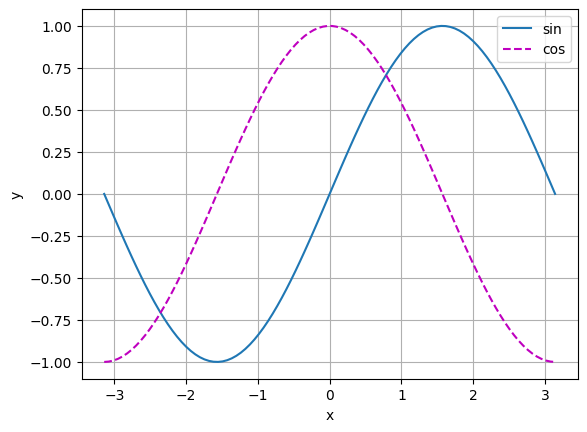

In [627]:
from matplotlib import pyplot

axes = pyplot.gca()
axes.set_xlabel("x"), axes.set_ylabel("y")
axes.grid()

axes.plot(x.detach(), y.detach())
axes.plot(x.detach(), grad, "m--")
axes.legend(["sin", "cos"])

tensor([-2.3908e+00, -2.3084e+00, -2.2153e+00, -2.1119e+00, -1.9989e+00,
        -1.8772e+00, -1.7475e+00, -1.6106e+00, -1.4675e+00, -1.3191e+00,
        -1.1663e+00, -1.0102e+00, -8.5174e-01, -6.9212e-01, -5.3241e-01,
        -3.7374e-01, -2.1728e-01, -6.4212e-02,  8.4244e-02,  2.2685e-01,
         3.6235e-01,  4.8944e-01,  6.0680e-01,  7.1306e-01,  8.0678e-01,
         8.8648e-01,  9.5056e-01,  9.9732e-01,  1.0249e+00,  1.0311e+00,
         1.0137e+00,  9.6978e-01,  8.9600e-01,  7.8821e-01,  6.4116e-01,
         4.4798e-01,  1.9950e-01, -1.1697e-01, -5.1948e-01, -1.0347e+00,
        -1.7033e+00, -2.5908e+00, -3.8079e+00, -5.5546e+00, -8.2254e+00,
        -1.2692e+01, -2.1218e+01, -4.1366e+01, -1.1302e+02, -9.9795e+02,
        -9.9795e+02, -1.1302e+02, -4.1366e+01, -2.1218e+01, -1.2692e+01,
        -8.2254e+00, -5.5546e+00, -3.8079e+00, -2.5908e+00, -1.7033e+00,
        -1.0347e+00, -5.1948e-01, -1.1697e-01,  1.9950e-01,  4.4798e-01,
         6.4116e-01,  7.8821e-01,  8.9600e-01,  9.6

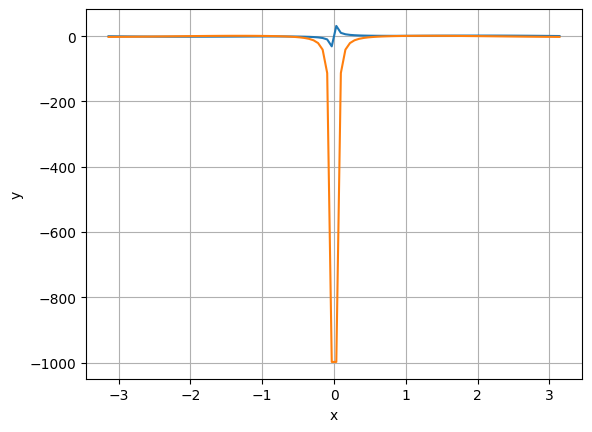

In [628]:
# 5 - just printing plot
range = np.linspace(- np.pi, np.pi, 100)
x = torch.tensor(range, requires_grad=True)

y = ((torch.log(x**2)) * torch.sin(x)) + x**(-1)
y.sum().backward(retain_graph=True)

axes = pyplot.gca()
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.grid()

axes.plot(x.detach(), y.detach())
axes.plot(x.detach(), x.grad)
x.grad